<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Computer_Vision_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Northwestern MSDS

422 - Practical Machine Learning

Jason Lee

## Cats vs. Dogs + Deep Learning

## Management Problem

Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. Part of this recommendation may concern information about the initial images themselves (input data for the classification task). 

*   What type of machine learning model works best? 

*   If it is a convolutional neural network, what type of network should we use?

*   What types of images work best?

# Programming Work

In [ ]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

# modeling routines from Scikit Learn packages
import tensorflow as tf
from keras.datasets import mnist
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score 


## Ingest

In [ ]:
# get data
import os
from six.moves.urllib.request import urlretrieve

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = "/tmp/mnist-data"

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.


## View data

In [ ]:

import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

with gzip.open(test_data_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'image count', 'rows', 'columns']:
        # struct.unpack reads the binary data provided by f.read.
        # The format string '>i' decodes a big-endian integer, which
        # is the encoding of the data.
        print(field, struct.unpack('>i', f.read(4))[0])
    
    # Read the first 28x28 set of pixel values. 
    # Each pixel is one byte, [0, 255], a uint8.
    buf = f.read(28 * 28)
    image = numpy.frombuffer(buf, dtype=numpy.uint8)
  
    # Print the first few values of image.
    print('First 10 pixels:', image[:10])



magic number 2051
image count 10000
rows 28
columns 28
First 10 pixels: [0 0 0 0 0 0 0 0 0 0]


## EDA

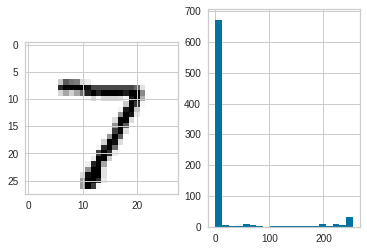

In [ ]:
get_ipython().magic(u'matplotlib inline')

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

ax2.hist(image, bins=20, range=[0,255]);



## Scale Data

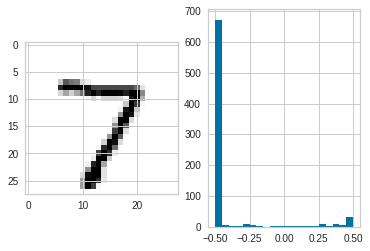

In [ ]:

# Let's convert the uint8 image to 32 bit floats and rescale 
# the values to be centered around 0, between [-0.5, 0.5]. 
# 
# We again plot the image and histogram to check that we 
# haven't mangled the data.
scaled = image.astype(numpy.float32)
scaled = (scaled - (255 / 2.0)) / 255
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(scaled.reshape(28, 28), cmap=plt.cm.Greys);
ax2.hist(scaled, bins=20, range=[-0.5, 0.5]);


In [ ]:

with gzip.open(test_labels_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'label count']:
        print(field, struct.unpack('>i', f.read(4))[0])

    print('First label:', struct.unpack('B', f.read(1))[0])


magic number 2049
label count 10000
First label: 7


In [ ]:

IMAGE_SIZE = 28
PIXEL_DEPTH = 255

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
  
    For MNIST data, the number of channels is always 1.

    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and dimensions; we know these values.
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
        return data

train_data = extract_data(train_data_filename, 60000)
test_data = extract_data(test_data_filename, 10000)



Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz


Training data shape (60000, 28, 28, 1)


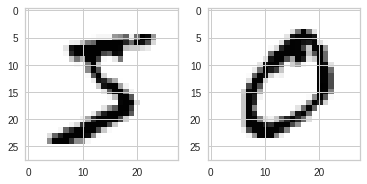

In [ ]:

print('Training data shape', train_data.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_data[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(train_data[1].reshape(28, 28), cmap=plt.cm.Greys);


# Looks good. Now we know how to index our full set of training and test images.

# ### Label data
# 
# Let's move on to loading the full set of labels. As is typical in classification problems, we'll convert our input labels into a [1-hot](https://en.wikipedia.org/wiki/One-hot) encoding over a length 10 vector corresponding to 10 digits. The vector [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], for example, would correspond to the digit 1.


## Split Data

In [ ]:


NUM_LABELS = 10

def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and count; we know these values.
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    # Convert to dense 1-hot representation.
    return (numpy.arange(NUM_LABELS) == labels[:, None]).astype(numpy.float32)

train_labels = extract_labels(train_labels_filename, 60000)
test_labels = extract_labels(test_labels_filename, 10000)


# As with our image data, we'll double-check that our 1-hot encoding of the first few values matches our expectations.


Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


In [ ]:


print('Training labels shape', train_labels.shape)
print('First label vector', train_labels[0])
print('Second label vector', train_labels[1])


# The 1-hot encoding looks reasonable.
# 
# ### Segmenting data into training, test, and validation
# 
# The final step in preparing our data is to split it into three sets: training, test, and validation. This isn't the format of the original data set, so we'll take a small slice of the training data and treat that as our validation set.


Training labels shape (60000, 10)
First label vector [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Second label vector [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:


VALIDATION_SIZE = 5000

validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]

train_size = train_labels.shape[0]

print('Validation shape', validation_data.shape)
print('Train size', train_size)



Validation shape (5000, 28, 28, 1)
Train size 50000


# Neural Networks

I will test out 3 different types of Neural Networks



1.   List item
2.   List item



## TensorFlow DNN

### Build Neural Network

In [ ]:
import tensorflow as tf

# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
BATCH_SIZE = 60
# We have only one channel in our grayscale images.
NUM_CHANNELS = 1
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(
  tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

train_labels_node = tf.placeholder(
    tf.float32, shape=(BATCH_SIZE, NUM_LABELS))


In [ ]:
# For the validation and test data, we'll just hold the entire dataset in
# one constant node.
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)


In [ ]:

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print('Done')


Done




*   Relu Activation
*   List item



In [ ]:

def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


In [ ]:

# Having defined the basic structure of the graph, we're ready to stamp out multiple copies for training, testing, and validation.
# 
# Here, we'll do some customizations depending on which graph we're constructing. `train_prediction` holds the training graph, for which we use cross-entropy loss and weight regularization. We'll adjust the learning rate during training -- that's handled by the `exponential_decay` operation, which is itself an argument to the `MomentumOptimizer` that performs the actual training.
# 
# The vaildation and prediction graphs are much simpler the generate -- we need only create copies of the model with the validation and test inputs and a softmax classifier as the output.



# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Done')

In [ ]:

# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()


# Now we're ready to perform operations on the graph. Let's start with one round of training. We're going to organize our training steps into batches for efficiency; i.e., training using a small set of examples at each step rather than a single example.


In [ ]:


BATCH_SIZE = 60

# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print('Done')

Done


In [ ]:

print(predictions[0])


[6.4470652e-05 3.5312430e-06 4.6149725e-03 3.5228557e-05 3.7312397e-01
 4.1718615e-04 5.9920108e-06 1.7964175e-04 1.4388385e-04 6.2141114e-01]


In [ ]:

# The highest probability in the first entry.
print('First prediction', numpy.argmax(predictions[0]))

# But, predictions is actually a list of BATCH_SIZE probability vectors.
print(predictions.shape)

# So, we'll take the highest probability for each vector.
print('All predictions', numpy.argmax(predictions, 1))


First prediction 9
(60, 10)
All predictions [9 4 2 7 7 7 8 7 7 9 7 7 7 4 4 9 7 7 3 2 4 0 7 9 7 4 7 4 7 4 1 7 7 0 4 7 9
 4 7 9 0 7 7 7 2 7 0 7 2 9 9 9 9 0 0 0 9 4 3 7]


In [ ]:

print('Batch labels', numpy.argmax(batch_labels, 1))


# Now we can compare the predicted and label classes to compute the error rate and confusion matrix for this batch.


Batch labels [3 8 7 9 9 0 1 1 5 2 0 3 8 4 7 5 2 6 4 7 1 8 0 9 2 0 0 1 9 2 5 3 6 4 3 5 6
 6 9 7 1 8 3 9 6 0 7 9 1 5 7 5 3 6 8 9 5 8 1 9]


0.03333333333333333


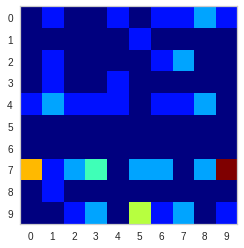

In [ ]:

correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(batch_labels, 1))
total = predictions.shape[0]

print(float(correct) / float(total))

confusions = numpy.zeros([10, 10], numpy.float32)
bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(batch_labels, 1))
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');


# Now let's wrap this up into our scoring function.

In [ ]:

def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.float32)
    bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Done')

Done


### Train Model

In [ ]:
# start timer
start = datetime.now()


# We'll need to train for some time to actually see useful predicted values. Let's define a loop that will go through our data. We'll print the loss and error periodically.
# 
# Here, we want to iterate over the entire data set rather than just the first batch, so we'll need to slice the data to that end.
# 
# (One pass through our training set will take some time on a CPU, so be patient if you are executing this notebook.)

# Train over the first 1/4th of our training set.
steps = train_size // BATCH_SIZE
for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % 100 == 0:
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
              validation_prediction.eval(), validation_labels)[0])


# The error seems to have gone down. Let's evaluate the results using the test set.
# 
# To help identify rare mispredictions, we'll include the raw count of each (prediction, label) pair in the confusion matrix.


# end time for everything
end = datetime.now()

# print timing
print("\nTraining Time = {}".format(end - start))


Step 0 of 833
Mini-batch loss: 3.02015 Error: 3.33333 Learning rate: 0.00950
Validation error: 2.5%
Step 100 of 833
Mini-batch loss: 2.95736 Error: 5.00000 Learning rate: 0.00950
Validation error: 2.4%
Step 200 of 833
Mini-batch loss: 2.83340 Error: 0.00000 Learning rate: 0.00950
Validation error: 2.1%
Step 300 of 833
Mini-batch loss: 2.83317 Error: 1.66667 Learning rate: 0.00950
Validation error: 2.5%
Step 400 of 833
Mini-batch loss: 2.85592 Error: 3.33333 Learning rate: 0.00950
Validation error: 2.2%
Step 500 of 833
Mini-batch loss: 2.78945 Error: 1.66667 Learning rate: 0.00950
Validation error: 2.0%
Step 600 of 833
Mini-batch loss: 2.75050 Error: 1.66667 Learning rate: 0.00950
Validation error: 2.0%
Step 700 of 833
Mini-batch loss: 2.71311 Error: 1.66667 Learning rate: 0.00950
Validation error: 2.0%
Step 800 of 833
Mini-batch loss: 2.73619 Error: 1.66667 Learning rate: 0.00950
Validation error: 2.1%

Training Time = 0:02:56.716146


### Results

In [ ]:
print(test_error)

1.9200000000000017


## Basic Neural Network

### Load Data

In [ ]:
import tensorflow as tf
from keras.datasets import mnist

# load data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# set up model
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=10,
                                             feature_columns=feature_columns)


y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

### Train Model

In [ ]:
# start timer
start = datetime.now()

# train model
dnn_clf.fit(x = x_train, y = y_train, batch_size = 50, steps = 40000)

# end time for everything
end = datetime.now()

# print timing
print("\nTraining Time = {}".format(end - start))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to the Estimator interface.
Instructions for up

### Results

In [ ]:
from sklearn.metrics import accuracy_score 

y_pred = list(dnn_clf.predict(x_test))
dnnScore = accuracy_score(y_test, y_pred)

Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ao_uxgb/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
print("DNN Accuracy Rating:", dnnScore*100, "%")

DNN Accuracy Rating: 94.69 %


In [ ]:
resultsDNN = dnn_clf.evaluate(x_test, y_test)

INFO:tensorflow:Starting evaluation at 2019-05-13T03:50:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ao_uxgb/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-13-03:50:50
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.9469, global_step = 40000, loss = 0.26439846


In [ ]:
print(resultsDNN)

{'loss': 0.26439846, 'accuracy': 0.9469, 'global_step': 40000}


# Conclusion

### Plot Results

Test error: 1.9%


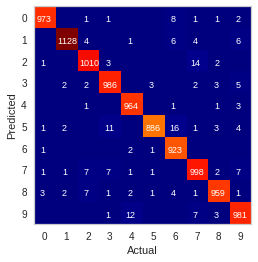

In [ ]:

test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')


# We can see here that we're mostly accurate, with some errors you might expect, e.g., '9' is often confused as '4'.
# 
# Let's do another sanity check to make sure this matches roughly the distribution of our test set, e.g., it seems like we have fewer '5' values.


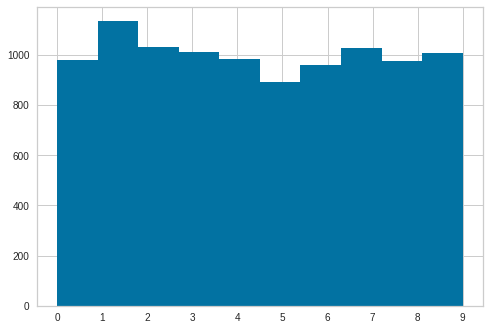

In [ ]:

plt.xticks(numpy.arange(NUM_LABELS))
plt.hist(numpy.argmax(test_labels, 1));


# Indeed, we appear to have fewer 5 labels in the test set. So, on the whole, it seems like our model is learning and our early results are sensible.
# 
# But, we've only done one round of training. We can greatly improve accuracy by training for longer. To try this out, just re-execute the training cell above.


In [ ]:
results_df = pd.DataFrame({'TestName': ['TensorFlow DNN', 'Basic NN', 'Keras CNN'],
   'Test Accuracy': [0.9808, 0.9469, 0.9921],
   'Training Time': ['0:02:56', '0:02:48', '1:23:30']})
results_df.set_index('TestName', inplace=True)

results_df

,Test Accuracy,Training Time
TestName,,
TensorFlow DNN,0.9808,0:02:56
Basic NN,0.9469,0:02:48
Keras CNN,0.9921,1:23:30




I trained 3 different neural networks. The Keras CNN model performed the best but the training time was almost an hour and a half. This was very long in comparison to the other models. The basic NN model trained the quickest but the results were inconsistent.

<br>

**I would recommend using the TensorFlow NN because it will save time/money during training but it maintains high accuracy predicting new data.**


# Cats and Dogs Jumpstart

In [ ]:
# Common imports for our work
import os 
import numpy as np
import tensorflow as tf
from datetime import datetime

In [ ]:
RANDOM_SEED = 9999

In [ ]:
# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
#CatsDogs# Old dimensions from MNIST no loger apply
#CatsDogs# height = 28
#CatsDogs# width = 28
height = 64
width = 64   

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# set working directory
import os
os.chdir("/content/drive/My Drive/422 - Practical Machine Learning/Colab Notebooks/Assignment 7/")
os.getcwd()

'/content/drive/My Drive/422 - Practical Machine Learning/Colab Notebooks/Assignment 7'

In [ ]:
# list files in data folder
!ls "cats_dogs_64-128/"

cats_1000_64_64_1.npy  dogs_1000_64_64_1.npy
cats_1000_64_64_3.npy  dogs_1000_64_64_3.npy


## Load Data

In [ ]:
#CatsDogs# 
# Documentation on npy binary format for saving numpy arrays for later use
#     https://towardsdatascience.com/
#             why-you-should-start-using-npy-file-more-often-df2a13cc0161
# Under the working directory, data files are in directory cats_dogs_64_128 
# Read in cats and dogs grayscale 64x64 files to create training data
cats_1000_64_64_1 = np.load('cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats_dogs_64-128/dogs_1000_64_64_1.npy')

In [ ]:
from matplotlib import pyplot as plt  # for display of images

def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

## EDA

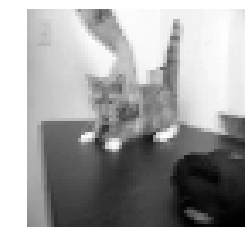

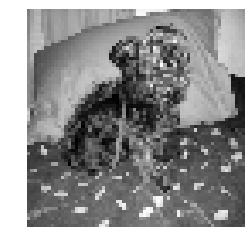

In [ ]:
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

## Build Model

In [ ]:
# 300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron
n_hidden1 = 300
n_hidden2 = 100

channels = 1  # When working with color images use channels = 3

n_inputs = height * width

#CatsDogs# Has two output values # MNIST had ten digits n_outputs = 10  
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

reset_graph()

In [ ]:
# load datasets
start=datetime.now()

# dnn... Deep neural network model from Geron Chapter 10
# Note that this model makes no use of the fact that we have
# pixel data arranged in rows and columns
# So a 64x64 matrix of raster values becomes a vector of 4096 input variables
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver()


end=datetime.now()
print(end-start)

Instructions for updating:
Colocations handled automatically by placer.
0:00:00.289358


In [ ]:
# Work the data for cats and dogs numpy arrays 
# These numpy arrays were generated in previous data prep work
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

In [ ]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

## Split Data

In [ ]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

## Train Model

In [ ]:

init = tf.global_variables_initializer()    

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model")



0 Train accuracy: 0.59 Test accuracy: 0.4875
1 Train accuracy: 0.59 Test accuracy: 0.4825
2 Train accuracy: 0.59 Test accuracy: 0.4825
3 Train accuracy: 0.59 Test accuracy: 0.4825
4 Train accuracy: 0.59 Test accuracy: 0.4825
5 Train accuracy: 0.59 Test accuracy: 0.4825
6 Train accuracy: 0.59 Test accuracy: 0.4825
7 Train accuracy: 0.59 Test accuracy: 0.4825
8 Train accuracy: 0.59 Test accuracy: 0.4825
9 Train accuracy: 0.59 Test accuracy: 0.4825
10 Train accuracy: 0.59 Test accuracy: 0.4825
11 Train accuracy: 0.59 Test accuracy: 0.4825
12 Train accuracy: 0.59 Test accuracy: 0.4825
13 Train accuracy: 0.59 Test accuracy: 0.4825
14 Train accuracy: 0.59 Test accuracy: 0.4825
15 Train accuracy: 0.59 Test accuracy: 0.4825
16 Train accuracy: 0.59 Test accuracy: 0.4825
17 Train accuracy: 0.59 Test accuracy: 0.4825
18 Train accuracy: 0.59 Test accuracy: 0.4825
19 Train accuracy: 0.59 Test accuracy: 0.4825
20 Train accuracy: 0.59 Test accuracy: 0.4825
21 Train accuracy: 0.59 Test accuracy: 0.482

## Keras CNN

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
from keras.datasets import mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [ ]:
batch_size = 128
num_classes = 10
epochs = 10

In [ ]:
img_rows, img_cols = 28, 28

In [ ]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# One hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()

In [ ]:
import tensorflow as tf 

### Adding layers

In [ ]:
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

### Train Model

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 510s 8ms/step - loss: 0.2417 - acc: 0.9258 - val_loss: 0.0494 - val_acc: 0.9837
Epoch 2/10
60000/60000 [==============================] - 501s 8ms/step - loss: 0.0765 - acc: 0.9777 - val_loss: 0.0357 - val_acc: 0.9890
Epoch 3/10
60000/60000 [==============================] - 496s 8ms/step - loss: 0.0550 - acc: 0.9845 - val_loss: 0.0372 - val_acc: 0.9883
Epoch 4/10
60000/60000 [==============================] - 497s 8ms/step - loss: 0.0470 - acc: 0.9858 - val_loss: 0.0330 - val_acc: 0.9891
Epoch 5/10
60000/60000 [==============================] - 498s 8ms/step - loss: 0.0379 - acc: 0.9884 - val_loss: 0.0234 - val_acc: 0.9923
Epoch 6/10
60000/60000 [==============================] - 496s 8ms/step - loss: 0.0326 - acc: 0.9900 - val_loss: 0.0277 - val_acc: 0.9909
Epoch 7/10
60000/60000 [==============================] - 499s 8ms/step - loss: 0.0283 - acc: 0.9911 - val_loss: 0.0238 - 

### Results

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.022031682752041887
Test accuracy: 0.9921
